In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.resnet import preprocess_input

In [29]:
# Paths to your dataset
train_path = '/content/drive/MyDrive/Data/train'
valid_path = '/content/drive/MyDrive/Data/valid'
test_path = '/content/drive/MyDrive/Data/test'


In [30]:

# Constants
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 32
CHANNELS = 1

In [31]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True
)

valid_generator = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True
)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True
)


Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [32]:
# Store class names
class_names = train_generator.class_names

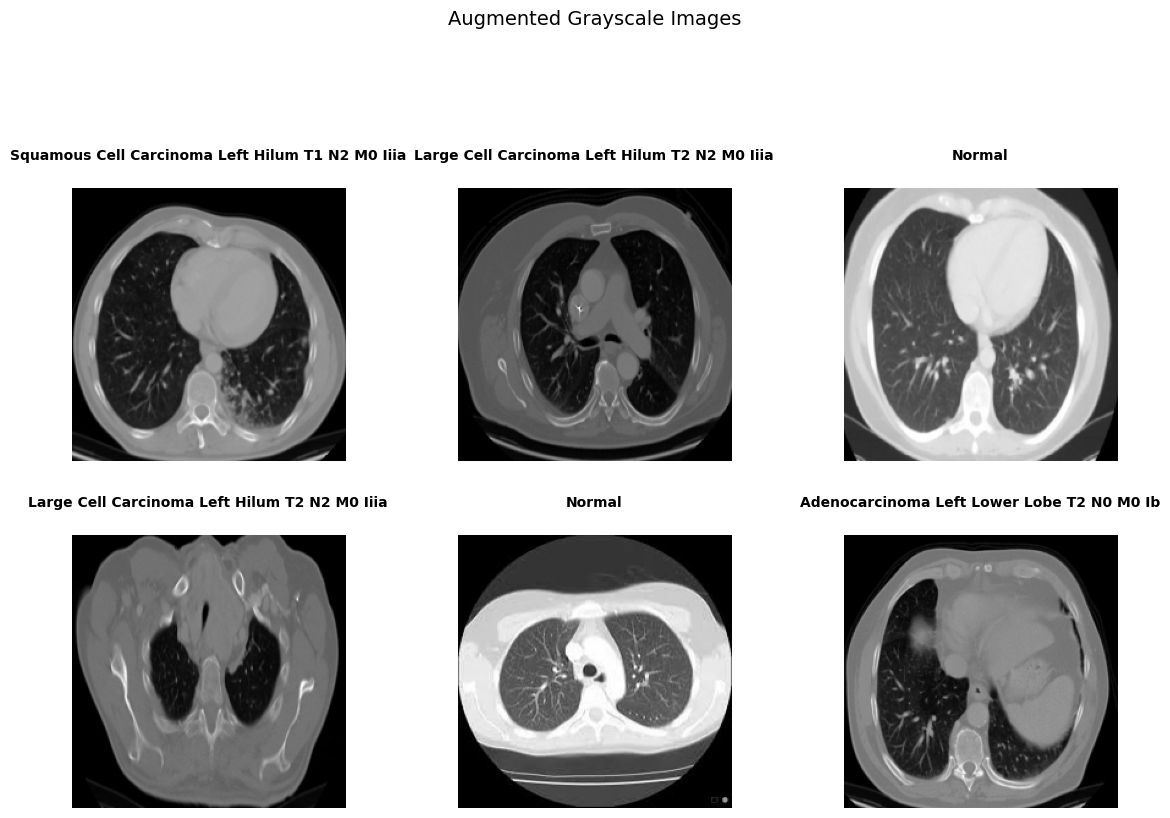

In [33]:
# Function to format class names with spacing
def format_class_name(class_name):
    return class_name.replace(".", " ").replace("_", " ").title()

# Display Augmented Images with Class Names
def display_augmented_images(generator, num_images=6):
    for images, labels in generator.take(1):
        plt.figure(figsize=(12, 8))
        for i in range(num_images):
            plt.subplot(2, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.axis('off')
            class_label = format_class_name(class_names[labels[i].numpy()])
            plt.title(class_label, pad=20, fontsize=10, fontweight="bold", wrap=True)
        plt.suptitle('Augmented Grayscale Images', fontsize=14, y=1.05)
        plt.tight_layout(pad=3.0)
        plt.show()
# Display augmented images
display_augmented_images(train_generator)

In [37]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(N_CLASSES, activation='softmax')
])



In [38]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint('chestmodel.keras', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/50
 9/20 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.2760 - loss: 96.3150

KeyboardInterrupt: 

In [35]:
# Evaluate the model
result = model.evaluate(test_generator)
print(f'Test Loss: {result[0]}, Test Accuracy: {result[1]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4497 - loss: 4.5869
Test Loss: 4.663570880889893, Test Accuracy: 0.43492063879966736


In [36]:
# Predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


AttributeError: '_PrefetchDataset' object has no attribute 'classes'

In [ ]:
# Model Evaluation
# 1. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


In [ ]:
# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 3. ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(N_CLASSES):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Displaying some predictions
plt.figure(figsize=(12, 12))
for images, labels in test_generator.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(f'Predicted: {y_pred_classes[i]}, Actual: {y_true[i]}')
        plt.axis('off')
plt.suptitle('Predictions on Test Images')
plt.show()


In [ ]:
# Image Detection with CNN
def simulate_detection(image):
    height, width = image.shape[0:2]
    box = [0.1 * width, 0.1 * height, 0.8 * width, 0.8 * height]  # [x1, y1, x2, y2]
    confidence = np.random.rand()  # Random confidence score
    return box, confidence

# Display detection results
for images_batch, _ in test_generator.take(1):
    for i in range(3):
        plt.imshow(images_batch[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        box, confidence = simulate_detection(images_batch[i])
        plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red', linewidth=2))
        plt.title(f'Confidence: {confidence:.2f}')
        plt.axis('off')
        plt.show()

In [ ]:
# Image Segmentation with CNN
def build_segmentation_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the segmentation model
segmentation_model = build_segmentation_model((IMAGE_SIZE, IMAGE_SIZE, 1))
segmentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Simulated training data for segmentation (replace with actual data)
# Assuming binary segmentation for simplicity
train_images = np.random.rand(100, IMAGE_SIZE, IMAGE_SIZE, 1)  # 100 random images
train_masks = np.random.randint(0, 2, (100, IMAGE_SIZE, IMAGE_SIZE, 1))  # Random binary masks

# Train the segmentation model
segmentation_history = segmentation_model.fit(train_images, train_masks, epochs=10, batch_size=8)

# Display segmentation results
for i in range(3):
    test_image = test_generator[i][0][0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE, 1)
    predicted_mask = segmentation_model.predict(test_image[np.newaxis, ...])
    plt.subplot(1, 2, 1)
    plt.imshow(test_image.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')
    plt.show()